# Лаб 5. Random Forest

Набор данных - https://www.kaggle.com/competitions/career-con-2019/overview

Основная цель соревнования — помочь роботам перемещаться в пространстве, используя данные с различных сенсоров.

- row_id: уникальный идентификатор каждой записи

- x, y, z: параметры, полученные с сенсоров (например, акселерометры)

- Другие измерения, которые могли включать скорость, ускорение и угловое смещение

- target: целевая переменная, описывающая направление движения робота (одно из направлений: up, down, left, right).

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder as le
import tqdm
import itertools
import math
import matplotlib.pyplot as plt


In [54]:
X = pd.read_csv('/content/drive/MyDrive/6 сем/обработка данных/Лаб 5/X_train.csv')
y = pd.read_csv('/content/drive/MyDrive/6 сем/обработка данных/Лаб 5/y_train.csv')
y['label'] = le().fit_transform(y.surface)

feature_columns = X.columns.to_list()[3:]

X_norm = []
y_norm = []
for series_id, group in X.groupby("series_id"):
    features = group[feature_columns]
    col_names = list(itertools.product(features.index, features.columns))
    X_norm.append([features.loc[comb] for comb in list(itertools.product(features.index, features.columns))])
    y_norm.append(y[y.series_id == series_id].iloc[0].label)

X = pd.DataFrame(X_norm, columns=col_names)
y = pd.Series(y_norm)

df = pd.concat([X, y], axis=1)
df = df.rename(columns={0: "y"})

In [12]:
df

,"(487552, orientation_X)","(487552, orientation_Y)","(487552, orientation_Z)","(487552, orientation_W)","(487552, angular_velocity_X)","(487552, angular_velocity_Y)","(487552, angular_velocity_Z)","(487552, linear_acceleration_X)","(487552, linear_acceleration_Y)","(487552, linear_acceleration_Z)",...,"(487679, orientation_Y)","(487679, orientation_Z)","(487679, orientation_W)","(487679, angular_velocity_X)","(487679, angular_velocity_Y)","(487679, angular_velocity_Z)","(487679, linear_acceleration_X)","(487679, linear_acceleration_Y)","(487679, linear_acceleration_Z)",y
0,-0.75853,-0.63435,-0.104880,-0.105970,0.107650,0.017561,0.000767,-0.748570,2.1030,-9.7532,...,-0.63306,-0.104610,-0.106840,0.073856,0.020353,0.018466,-0.534260,0.80346,-10.6970,2
1,-0.95896,0.24074,0.030758,-0.146610,0.283420,0.002192,-0.050810,2.184800,2.2526,-8.9503,...,0.24230,0.031996,-0.145870,0.071436,0.030853,0.057280,0.006624,2.07300,-9.7037,1
2,-0.50944,-0.84779,-0.129460,-0.070378,-0.006752,-0.026183,0.088730,0.399320,3.6066,-5.7442,...,-0.84490,-0.128560,-0.071282,0.072494,-0.032537,0.030181,-1.676200,3.03240,-8.2569,1
3,-0.93940,0.31003,0.038299,-0.141230,-0.326890,0.070941,-0.065173,0.602480,1.7016,-7.1944,...,0.31147,0.038584,-0.140510,0.012442,0.000170,0.007339,-2.492600,0.62588,-4.3806,1
4,-0.88673,0.43740,0.061771,-0.136300,0.025631,0.048867,-0.122520,-0.132890,3.1301,-9.8091,...,0.41646,0.058247,-0.136950,0.038755,0.075828,-0.144730,-0.782520,2.66270,-9.1168,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3805,-0.22662,0.96216,0.145290,-0.042217,0.129890,0.071889,0.059335,-0.943770,1.7627,-10.6590,...,0.96147,0.144740,-0.042549,-0.013031,0.021918,-0.001192,1.428600,5.17960,-11.7700,7
3806,0.54436,0.82522,0.129630,0.076684,-0.001225,0.002471,0.001731,0.081371,2.9258,-9.3724,...,0.82789,0.130070,0.076016,0.001505,-0.001501,0.003235,0.147010,2.88320,-9.3713,8
3807,-0.39188,0.90642,0.142640,-0.067059,-0.016774,0.202660,-0.331640,1.964000,3.9600,-9.2972,...,0.88360,0.135370,-0.071571,0.074895,0.154310,-0.426740,-4.043800,-1.46370,-10.3020,2
3808,-0.27113,0.95067,0.142980,-0.047749,0.040843,-0.046273,-0.017181,0.042753,6.3317,-10.7450,...,0.95470,0.143660,-0.044816,0.079295,-0.002153,0.043486,2.799200,6.65260,-8.3813,7


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import StandardScaler
import numpy as np

In [14]:
X = df.drop('y', axis=1)
y = df['y'].values

In [15]:
X = StandardScaler().fit_transform(X)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [17]:
from sklearn.tree import DecisionTreeRegressor

In [45]:
import numpy as np
from dataclasses import dataclass
import sys

class ActivityClassifier():
    def __init__(self, max_depth):
        self.regressors = []
        self.max_depth=max_depth
    def fit(self, X: np.ndarray, y: np.ndarray, y_one_hot: bool) -> None:
        if not y_one_hot:
            y = np.eye(np.unique(y).shape[0])[y]
        self.regressors = [DecisionTreeRegressor(max_depth=3) for i in range(y.shape[1])]
        for i in range(y.shape[1]):
            self.regressors[i].fit(X, y[:, i])

    def predict(self, X: np.ndarray, y_one_hot: bool) -> np.ndarray:
        out = np.zeros(X.shape[0])
        y = self.predict_proba(X)
        if y_one_hot:
            for i,_ in enumerate(y):
                max_ = np.argmax(y[i])
                y[i] = 0
                y[i, max_] = 1
            return y

        for i,_ in enumerate(y):
            out[i] = np.argmax(y[i])
        return out

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        y = np.zeros([X.shape[0], len(self.regressors)])
        for i, reg in enumerate(self.regressors):
            y[:, i] = reg.predict(X)

        return y

In [46]:
class Bagger():
    def __init__(self, Classifier_, n_estimators: int = 100, random_state:int=None, **classifier_params: dict):
        self.Classifier = Classifier_
        self.classifier_params = classifier_params
        self.n_estimators = n_estimators
        self.classifiers = []
        self.random_state = random_state
        self.n_classes = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self.n_classes = np.unique(y).shape[0]
        np.random.seed(self.random_state)
        self.classifiers = [self.Classifier(**self.classifier_params) for i in range(self.n_estimators)]
        for clf in tqdm.tqdm(self.classifiers):
            sample = np.random.randint(low=0, high=X.shape[0], size=X.shape[0], dtype=int)
            n_features = math.ceil(X.shape[1] - np.sqrt(X.shape[1]))
            features = np.random.choice(np.arange(0, X.shape[1]), n_features, replace=True)
            sample_X = X[sample]
            sample_X[:, features] = 0
            sample_y = y[sample]
            sample_y = np.eye(self.n_classes)[sample_y]
            clf.fit(sample_X, sample_y, y_one_hot=True)


    def predict(self, X: np.ndarray) -> np.ndarray:
        predicts = np.zeros([X.shape[0], self.n_classes], dtype=float)
        out = np.zeros(X.shape[0], dtype=int)
        for i, clf in enumerate(self.classifiers):
            predicts += clf.predict_proba(X)
        print(predicts.shape)
        for i,pred in enumerate(predicts):
            out[i] = np.argmax(pred)
        return out

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        y = np.zeros([X.shape[0], self.n_classes])
        for i, reg in enumerate(self.classifiers):
            y += reg.predict_proba(X)
        return y / len(self.classifiers)


In [47]:
my_forest = Bagger(ActivityClassifier, random_state=42, max_depth=4)

In [48]:
my_forest.fit(X_train, y_train)

100%|██████████| 100/100 [09:02<00:00,  5.43s/it]


In [49]:
predicts = my_forest.predict(X_test)
precision, recall, f_score, _ = precision_recall_fscore_support(y_test, predicts)

(762, 9)


Accuracy: 0.5577427821522309
Precision on class 0: 0.5
Recall on class 0: 0.20512820512820512
F1-score on class 0: 0.2909090909090909




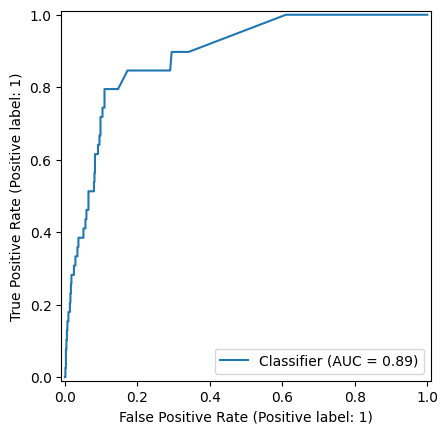

Precision on class 1: 0.5190476190476191
Recall on class 1: 0.7077922077922078
F1-score on class 1: 0.5989010989010989




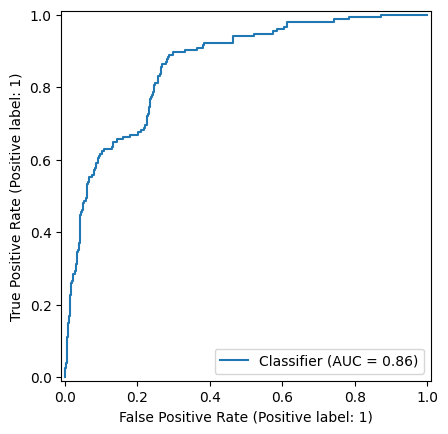

Precision on class 2: 0.5217391304347826
Recall on class 2: 0.2891566265060241
F1-score on class 2: 0.37209302325581395




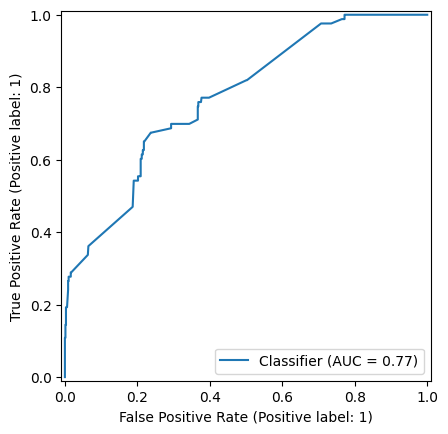

Precision on class 3: 0.3333333333333333
Recall on class 3: 0.2
F1-score on class 3: 0.25




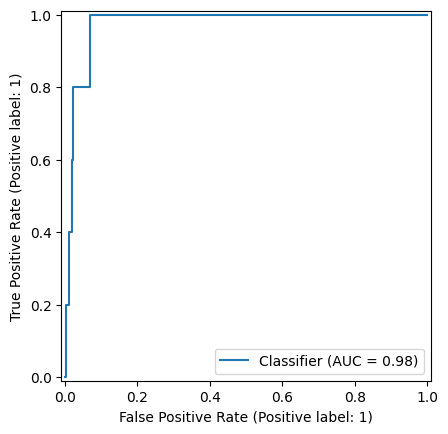

Precision on class 4: 0.967741935483871
Recall on class 4: 0.43478260869565216
F1-score on class 4: 0.6




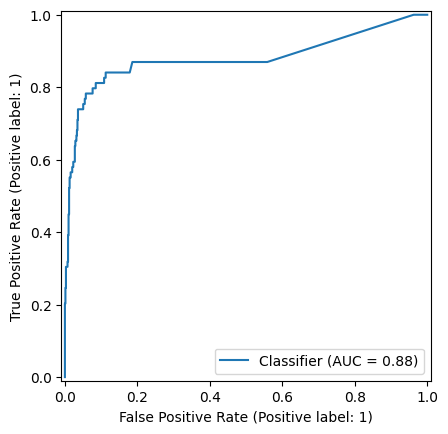

Precision on class 5: 0.5562130177514792
Recall on class 5: 0.734375
F1-score on class 5: 0.632996632996633




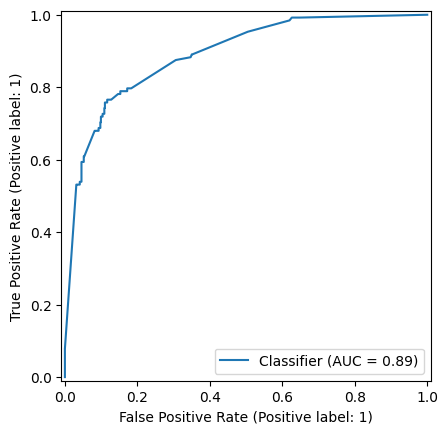

Precision on class 6: 0.4576271186440678
Recall on class 6: 0.5294117647058824
F1-score on class 6: 0.4909090909090909




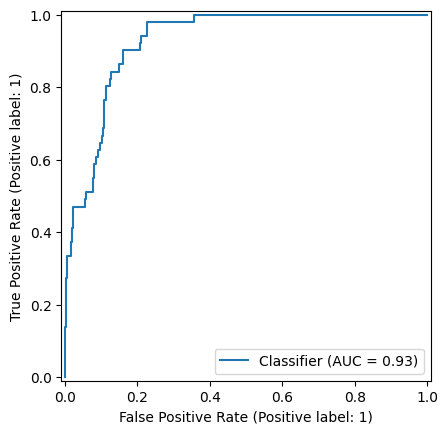

Precision on class 7: 0.5071428571428571
Recall on class 7: 0.7395833333333334
F1-score on class 7: 0.6016949152542372




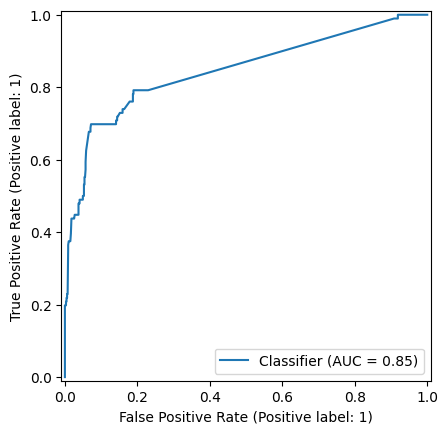

Precision on class 8: 0.6931818181818182
Recall on class 8: 0.44525547445255476
F1-score on class 8: 0.5422222222222223




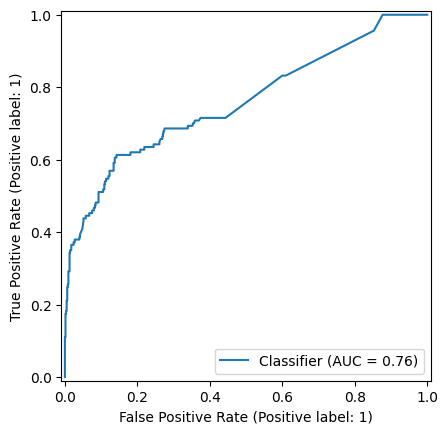

In [52]:
print('Accuracy:', accuracy_score(y_test, predicts))
for i,_ in enumerate(precision):
    print(f'Precision on class {i}: {precision[i]}')
    print(f'Recall on class {i}: {recall[i]}')
    print(f'F1-score on class {i}: {f_score[i]}')
    print('\n')
    probas = my_forest.predict_proba(X_test)
    RocCurveDisplay.from_predictions(np.eye(np.unique(y_test).shape[0])[y_test][:,i], probas[:,i])
    plt.show()